In [1]:
# sys.path.append('../../')
import pandas as pd
from pathlib import Path
import numpy as np
from os import listdir
from os.path import isfile, join,isdir
import matplotlib.pyplot  as plt
import commons as cm
import mungling as dm
import matplotlib.pyplot as plt
import seaborn as sns
from  scipy import stats 


### Figures parameters

In [2]:
behaviour_color={'exploration':'green','approach':'blue','contact':'red'}
figures_path='analysed/figures/'
# pd.set_option('display.max_rows', None)
# pd.reset_option("display.max_rows")


### Load the data

In [3]:
raw_matrix_df_aux=pd.read_excel('analysed/tables/raw_matrix_df_thr_0.1.xlsx')
thr=raw_matrix_df_aux['behaviour_thr'].values[0]


#### Remove incomplete trials, group by day and add some columns in inamigary numbers for angle calculations

In [4]:

day=2

if day==2:
    toremove=['87'] 


raw_matrix_df=(raw_matrix_df_aux
               .query('day==@day')
               .query("mouse_num!=@toremove")
            )

## Ad columns of inmaginary numbers
raw_matrix_df['complex']=np.cos(raw_matrix_df['angle_head_cricket'])+  1j *np.sin(raw_matrix_df['angle_head_cricket'])
raw_matrix_df['angle_deg_from_complex']=np.angle(raw_matrix_df['complex'],deg=True)
raw_matrix_df['angle_rad_from_complex']=np.angle(raw_matrix_df['complex'],deg=False)



#### Add filtered speed and global column time to 0, and a final row with a contact just in case.

In [5]:
from scipy.signal import medfilt

for session in raw_matrix_df['session'].unique():
    index=raw_matrix_df['session']==session
    raw_matrix_df.loc[index,'speed_cm_s_med_filt']=medfilt(raw_matrix_df.loc[index,'speed_cm_s'],3)
    raw_matrix_df.loc[index,'session_time']=raw_matrix_df.loc[index,'time']-raw_matrix_df.loc[index,'time'].values[0]
    raw_matrix_df.loc[index,'session_end_s']=raw_matrix_df.loc[index,'session_time'].values[-1]

    if session=='f_623_day_2_trial_3_20230804_124239':
        aux_row_index=raw_matrix_df.loc[index,'behaviour'].iloc[-7::].index
        print(raw_matrix_df.loc[aux_row_index,'behaviour'])
        raw_matrix_df.loc[aux_row_index,'behaviour']=pd.NA
        raw_matrix_df.loc[aux_row_index,'beh_counter']=pd.NA

   # add a final conctact row
    aux_row_index=raw_matrix_df.loc[index].index[-1]
    aux_row=raw_matrix_df.loc[index].iloc[-1]
    max_beh_counter=np.max(raw_matrix_df.loc[index,['beh_counter']])
    aux_row['beh_counter']=max_beh_counter+1
    aux_row['behaviour']='contact'
    raw_matrix_df.loc[aux_row_index]=aux_row




c:\Users\arturoV\AppData\Local\miniconda3\envs\analysis\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\arturoV\AppData\Local\miniconda3\envs\analysis\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\arturoV\AppData\Local\miniconda3\envs\analysis\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(ax

15528            NaN
15529            NaN
15530            NaN
15531    exploration
15532    exploration
15533            NaN
15534    exploration
Name: behaviour, dtype: object


c:\Users\arturoV\AppData\Local\miniconda3\envs\analysis\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\arturoV\AppData\Local\miniconda3\envs\analysis\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\arturoV\AppData\Local\miniconda3\envs\analysis\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(ax

#### Functions to obtain mean angles and magnitudes from agreegations

In [6]:
def circular_mean_angle(complex_numbers:pd.Series):
    """Function to calculate circular mean from complex numbers

    Args:
        complex_numbers (pd.Series): complex_numbers, usually betwwen (pi,-pi) for more coherent stuff. I want 
        oposite angles to give an angle of 0. However absolute avlues of -45 or -135 are really strange.

    Returns:
        _type_: _description_
    """
    suma_com=np.sum(complex_numbers)
    final_angle=np.angle(suma_com,deg=False)


    return final_angle

def circular_magnitude(complex_numbers:pd.Series):
    """Function to calculate final magnitude from the sum of complex numbers

    Args:
        complex_numbers (pd.Series): angels in radians, usually betwwen (pi,-pi) for more coherent stuff. I want 
        oposite angles to give an angle of 0. However absolute avlues of -45 or -135 are really strange.

    Returns:
        _type_: _description_
    """
    suma_com=np.sum(complex_numbers)
    final_magnitude=np.abs(suma_com)/len(complex_numbers)


    return final_magnitude


def data_summary(df:pd.DataFrame,col_name:str,group_by:str):
    """Funtion for summarrinz data

    Args:
        df (pd.DataFrame): _description_
        col_name (str): bname of the column to summarize
        group_by (str): groupby category
    """
    summary= (df.groupby([group_by])
                .agg(mean=(col_name,np.mean),
                    std=(col_name,np.std),
                    q1= (col_name,lambda x: x.quantile(0.25) ),
                    q2= (col_name,lambda x: x.quantile(0.50) ),
                    median= (col_name,lambda x: x.median()),
                    q3=(col_name,lambda x: x.quantile(0.75)),
                    ICR=(col_name,lambda x:x.quantile(0.75)- x.quantile(0.25)),
                    max=(col_name,np.max),
                    min=(col_name,np.min)))
    display(summary)

#### Compute behaviour matrix: A matrix where each behaviour counter is agregated by time.

In [7]:
behaviour_matrix_df=(raw_matrix_df.groupby(['phenotype','mouse_num','day','trial','session','beh_counter','behaviour'])
                .agg(diff_time=('diff_time',np.sum),
                     n_bins=('diff_time',len),
                     time_0=('session_time',np.min),
                     time_end=('session_time',np.max),
                     max_speed_to_c=('to_cricket_cm_s',np.max),
                     min_speed_to_c=('to_cricket_cm_s',np.min),
                     mean_speed_to_c=('to_cricket_cm_s',np.mean),
                     distance_to_c=('diff_head_cricket_cm',np.sum),
                     max_speed=('speed_cm_s_med_filt',np.max),
                     min_speed=('speed_cm_s_med_filt',np.min),
                     mean_speed=('speed_cm_s_med_filt',np.mean),
                     max_behaviour_dist=('distance_head_cricket_cm',np.max),
                     min_behaviour_dist=('distance_head_cricket_cm',np.min),
                     first_beh_distance=('distance_head_cricket_cm',lambda x: x.iloc[0]),
                     mean_angle=('complex',circular_mean_angle),
                     magnitude=('complex',circular_magnitude))
                     ).reset_index()
                    
## Ad columns of inmaginary numbers
behaviour_matrix_df['complex']=np.cos(behaviour_matrix_df['mean_angle'])+  1j *np.sin(behaviour_matrix_df['mean_angle'])
behaviour_matrix_df['angle_deg_from_complex']=np.angle(behaviour_matrix_df['complex'],deg=True)
behaviour_matrix_df['angle_rad_from_complex']=np.angle(behaviour_matrix_df['complex'],deg=False)

#### Filter data by and select only approaches that finish in a contact

Count for each session number of contacts after an approach

In [8]:
sessions=behaviour_matrix_df.loc[:,['session','mouse_num','phenotype']].groupby(['session','phenotype','mouse_num']).count().reset_index()


### Create raw matrix and behaviour matrix of appraoches that lead to a contact

In [9]:
contact_approach=sessions
contact_approach['contact_approach']=0
contact_approach['contacts']=0
contact_approach['approaches']=0

approaches_contact_mat=[]
contacts_mat=[]
for index,session in enumerate(sessions['session'].unique()):
    data=behaviour_matrix_df.query("session==@session")

    aux_counter=list((data.query("behaviour=='approach'")['beh_counter']+1).values)
    posible_contacts=data.query("beh_counter==@aux_counter")
    number_approaches=len(aux_counter)

    contacts=posible_contacts.query("behaviour=='contact'")
    contacts_mat.append(contacts)
    number_contacts=len(contacts)

    # compute matrix list where off approaches that finish in contact
    aux_1=list(contacts['beh_counter']-1)
    approaches_end_contact=data.query('beh_counter==@aux_1')
    approaches_contact_mat.append(approaches_end_contact)

    contact_approach.iloc[index,3]=(number_contacts)/(number_approaches)
    contact_approach.iloc[index,4]=number_contacts
    contact_approach.iloc[index,5]=number_approaches
    
behaviour_matrix_df=pd.concat(approaches_contact_mat)
contact_df=pd.concat(contacts_mat)

raw_matrix_df=(behaviour_matrix_df.loc[:,['session','beh_counter']]
                       .merge(raw_matrix_df,left_on=['session','beh_counter'],
                              right_on=['session','beh_counter'],how='inner')   
                     )

In [10]:
#Check min numbers of bins for exploration or approach behaviour
behaviour_matrix_df.query("behaviour!='contact'").n_bins.min()

2

Check that all experiments at least one approache of the given thesholds.

In [11]:

behaviour_matrix_df.groupby(['phenotype']).agg(num=('mouse_num',lambda x: len(np.unique(x))))

,num
phenotype,
tg,7
wt,10


### Check that all experiments have approaches and explorations for the given thersholds, for the 3 trials

In [12]:
aux=(behaviour_matrix_df
 .query("behaviour=='approach'")
 .groupby(['phenotype','mouse_num'])
 .agg(num=('trial',lambda x: len(np.unique(x))))
 )#.query('num<3')
print(f'mouse with missing approaches: {aux.values}')

aux=(behaviour_matrix_df
 .query("behaviour=='exploration'")
 .groupby(['phenotype','mouse_num'])
 .agg(num=('trial',lambda x: len(np.unique(x))))
 ).query('num<3')
print(f'mouse with missing explorations: {aux.values}')


mouse with missing approaches: [[3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]]
mouse with missing explorations: []


In [13]:
aux=(behaviour_matrix_df
 .query("behaviour=='approach'")
 .groupby(['phenotype','mouse_num'])
 .agg(num=('trial',lambda x: len(np.unique(x))))
 )
aux

num
phenotype mouse_num     
tg        62           3
          63           3
          91           3
          93           3
          94           3
          98           3
          479          3
wt        26           3
          28           3
          61           3
          64           3
          90           3
          92           3
          483          3
          623          3
          629          3
          630          3

#### Construct last approach tables
Raw data filtered by first and last approaches for each session

In [14]:
last_approach_table=(behaviour_matrix_df
                     .query("behaviour=='approach'")
                     .groupby(['session'])
                     .agg(
                          last_approach=('beh_counter',lambda x: x.iloc[-1]))
                       .merge(raw_matrix_df,left_on=['session','last_approach'],
                              right_on=['session','beh_counter'],how='inner')   
                     )

first_approach_table=(behaviour_matrix_df
                     .query("behaviour=='approach'")
                     .groupby(['session'])
                     .agg(
                          first_approach=('beh_counter',lambda x: x.iloc[0])
                     )
                       .merge(raw_matrix_df,left_on=['session','first_approach'],
                              right_on=['session','beh_counter'],how='inner')   
                     )

### Behaviour matrix by first and last approaches for each session

In [15]:
last_approach_time=(last_approach_table.groupby(['phenotype','mouse_num','day','trial','session','beh_counter','behaviour'])
                .agg(diff_time=('diff_time',np.sum),
                     n_bins=('diff_time',len),
                     time_0=('session_time',np.min),
                     time_end=('session_time',np.max),
                     max_speed_to_c=('to_cricket_cm_s',np.max),
                     min_speed_to_c=('to_cricket_cm_s',np.min),
                     mean_speed_to_c=('to_cricket_cm_s',np.mean),
                     distance_to_c=('diff_head_cricket_cm',np.sum),
                     max_speed=('speed_cm_s_med_filt',np.max),
                     min_speed=('speed_cm_s_med_filt',np.min),
                     mean_speed=('speed_cm_s_med_filt',np.mean),
                     max_behaviour_dist=('distance_head_cricket_cm',np.max),
                     min_behaviour_dist=('distance_head_cricket_cm',np.min),
                     first_beh_distance=('distance_head_cricket_cm',lambda x: x.iloc[0]),
                     mean_angle=('complex',circular_mean_angle),
                     magnitude=('complex',circular_magnitude))
                     ).reset_index()


first_approach_time=(first_approach_table.groupby(['phenotype','mouse_num','day','trial','session','beh_counter','behaviour'])
                .agg(diff_time=('diff_time',np.sum),
                     n_bins=('diff_time',len),
                     time_0=('session_time',np.min),
                     time_end=('session_time',np.max),
                     max_speed_to_c=('to_cricket_cm_s',np.max),
                     min_speed_to_c=('to_cricket_cm_s',np.min),
                     mean_speed_to_c=('to_cricket_cm_s',np.mean),
                     distance_to_c=('diff_head_cricket_cm',np.sum),
                     max_speed=('speed_cm_s_med_filt',np.max),
                     min_speed=('speed_cm_s_med_filt',np.min),
                     mean_speed=('speed_cm_s_med_filt',np.mean),
                     max_behaviour_dist=('distance_head_cricket_cm',np.max),
                     min_behaviour_dist=('distance_head_cricket_cm',np.min),
                     first_beh_distance=('distance_head_cricket_cm',lambda x: x.iloc[0]),
                     mean_angle=('complex',circular_mean_angle),
                     magnitude=('complex',circular_magnitude))
                     ).reset_index()

Checking stuff

In [16]:
last_approach_time.groupby('phenotype').count()

,mouse_num,day,trial,session,beh_counter,behaviour,diff_time,n_bins,time_0,time_end,...,mean_speed_to_c,distance_to_c,max_speed,min_speed,mean_speed,max_behaviour_dist,min_behaviour_dist,first_beh_distance,mean_angle,magnitude
phenotype,,,,,,,,,,,,,,,,,,,,,
tg,21,21,21,21,21,21,21,21,21,21,...,21,21,21,21,21,21,21,21,21,21
wt,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,30


### Check that there is data for each trial

In [17]:
aux=(last_approach_time
 .query("behaviour=='approach'")
 .groupby(['phenotype','mouse_num'])
 .agg(num=('trial',lambda x: len(np.unique(x))))
 ).query('num<3')
print(f'mouse with missing approaches: {aux.values}')

aux=(first_approach_time
 .query("behaviour=='approach'")
 .groupby(['phenotype','mouse_num'])
 .agg(num=('trial',lambda x: len(np.unique(x))))
 ).query('num<3')
print(f'mouse with missing approaches: {aux.values}')

mouse with missing approaches: []
mouse with missing approaches: []


### Example figure of speed and cricket distance


Text(0.5, 1.0, 'm_98_day_2_trial_3_20230802_154745')

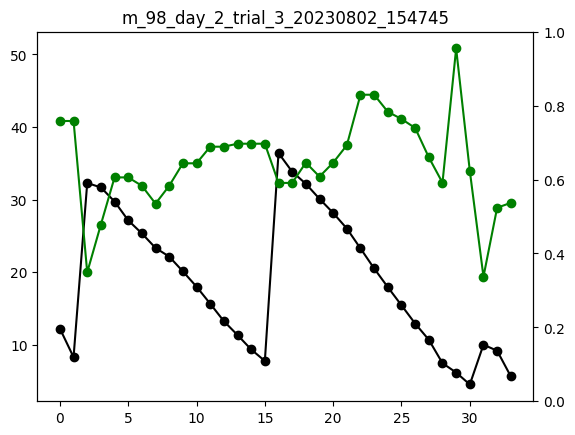

In [18]:
%matplotlib inline
data=raw_matrix_df.query("session=='m_98_day_2_trial_3_20230802_154745' &\
                            behaviour.notnull()")
x=np.arange(0,len(data),1)

fig,ax=plt.subplots(1)
# ax.plot(data['time'],data['distance_head_cricket_cm'],color='black')
# ax.plot(data['time'],data['angle_deg_from_complex'],'-',color='black')
ax.plot(x,data['distance_head_cricket_cm'],'o-',color='black')

ax2=ax.twinx()
ax.plot(x,data['speed_cm_s_med_filt'],'o-',color='green')
ax.set_title(session)

### Plot all sessions 

C:\Users\arturoV\AppData\Local\Temp\ipykernel_42972\3761037715.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(1)


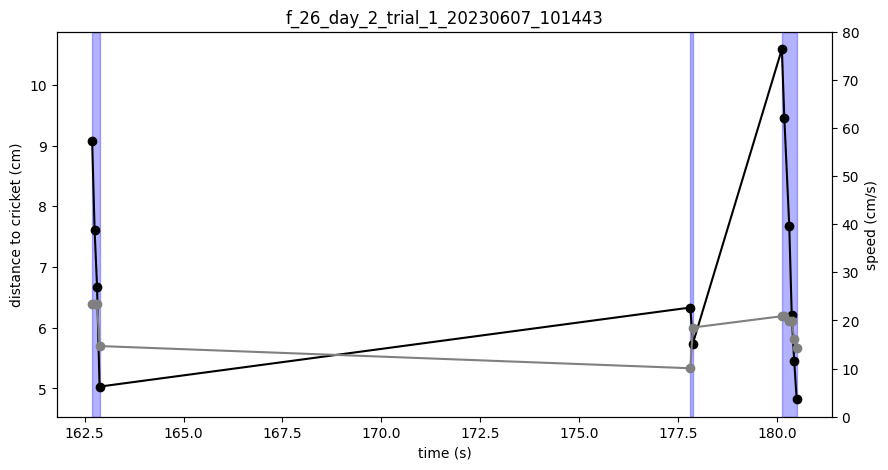

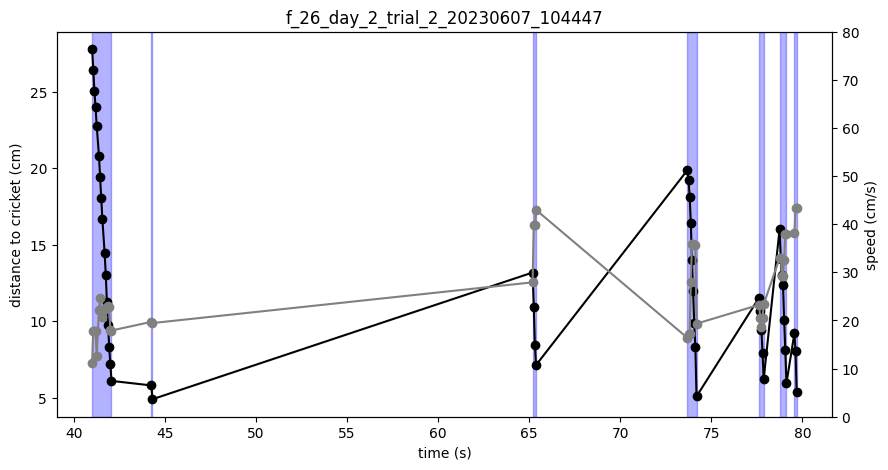

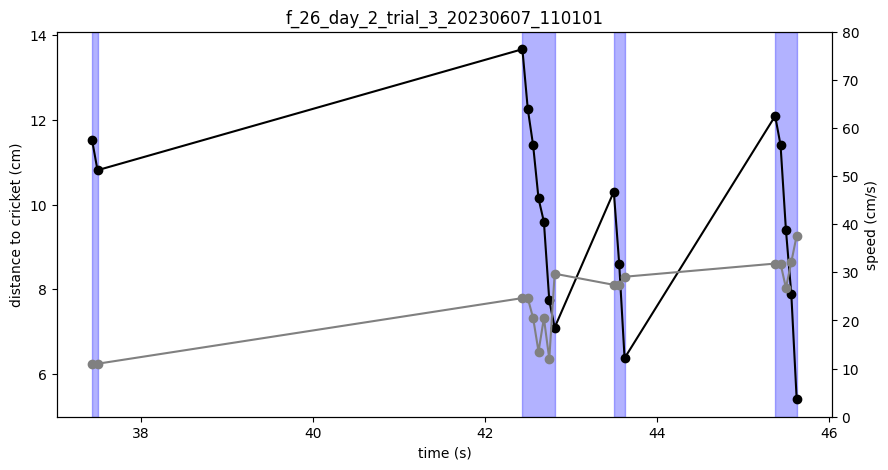

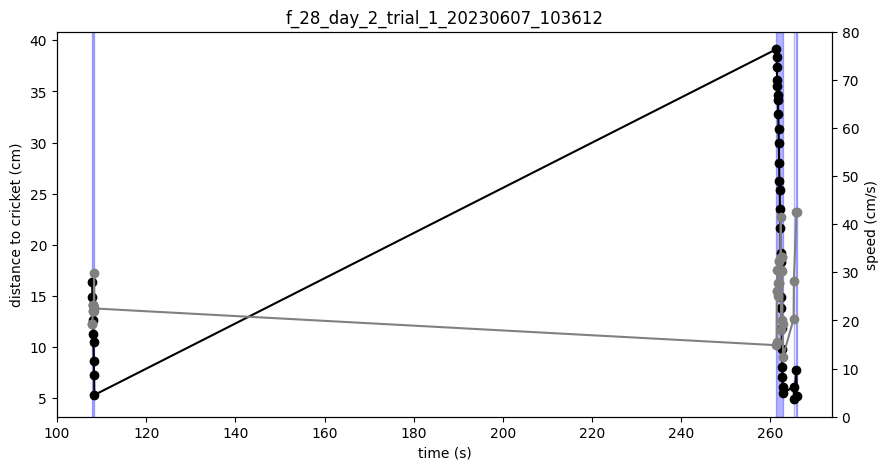

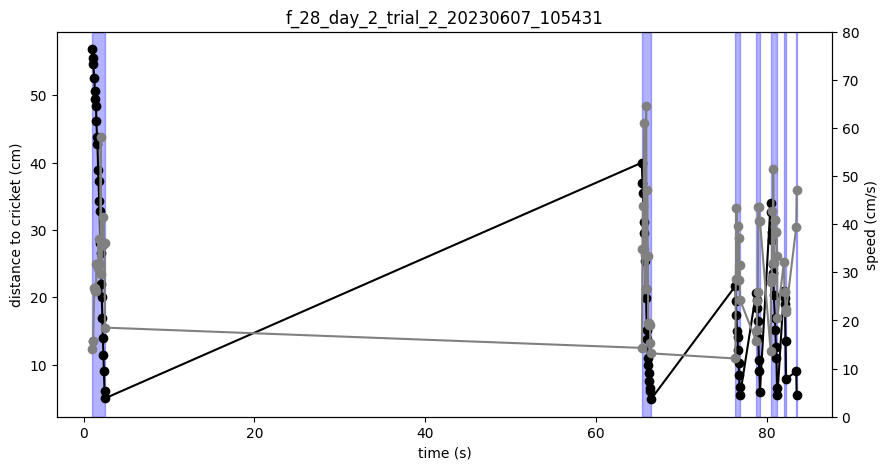

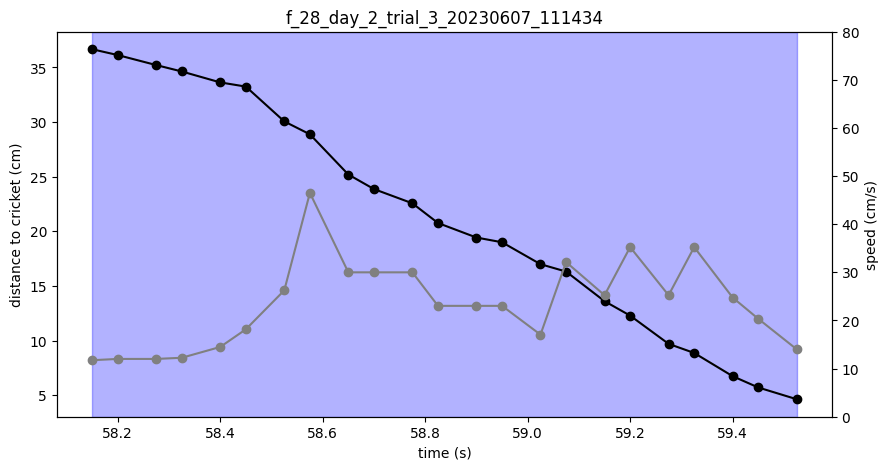

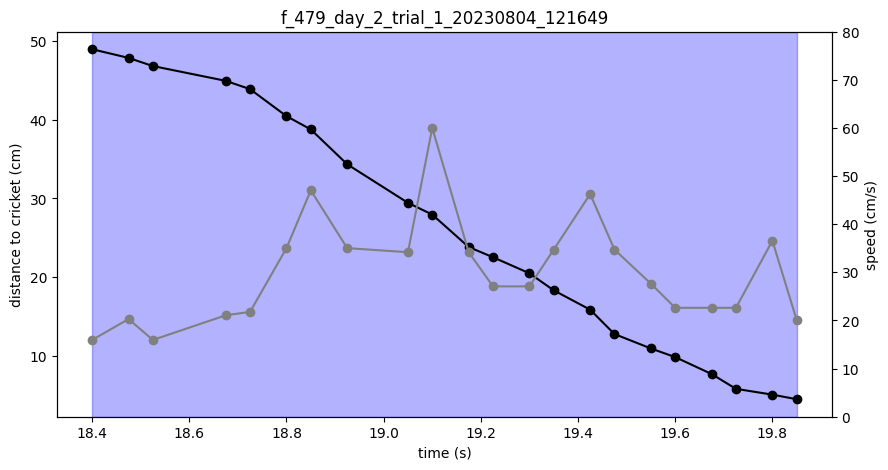

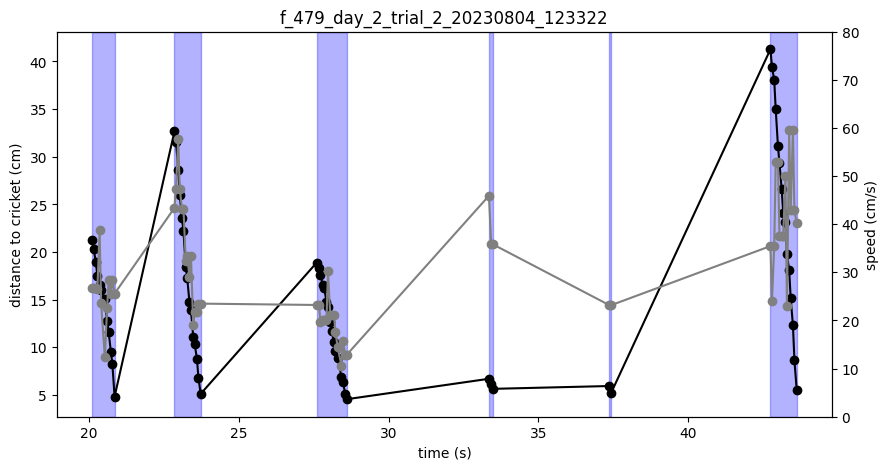

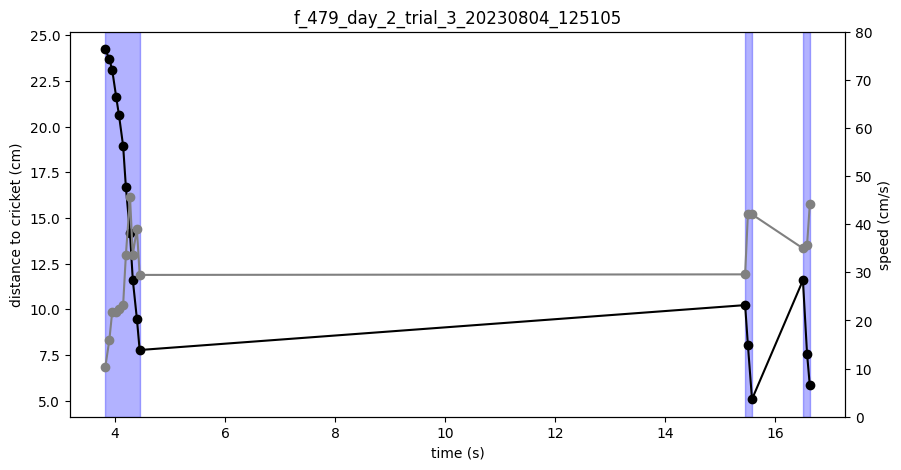

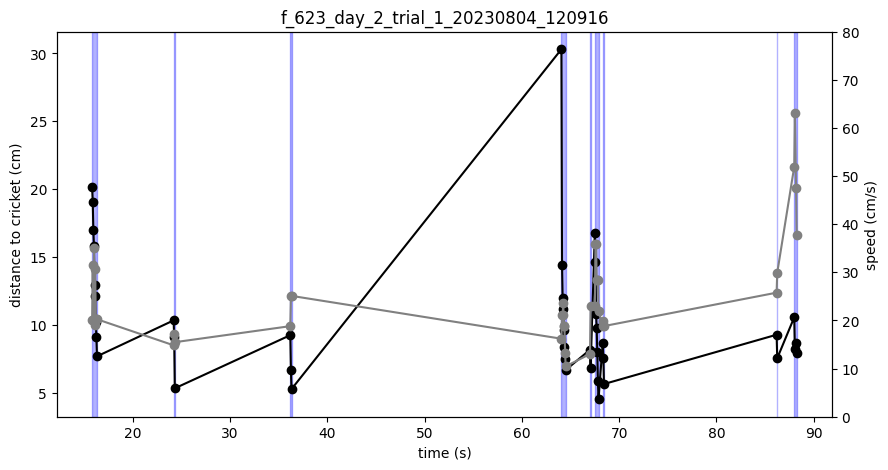

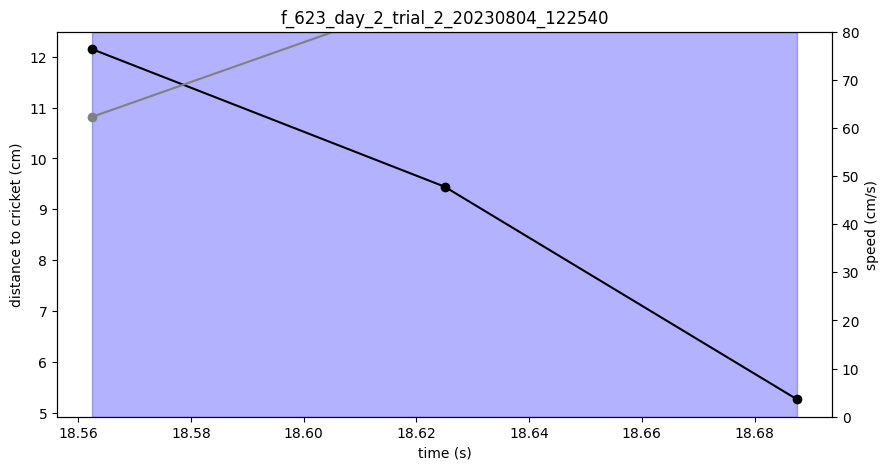

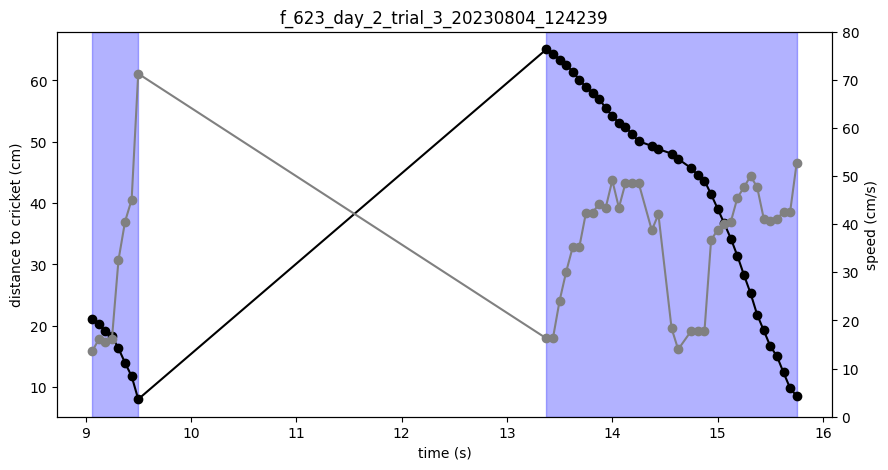

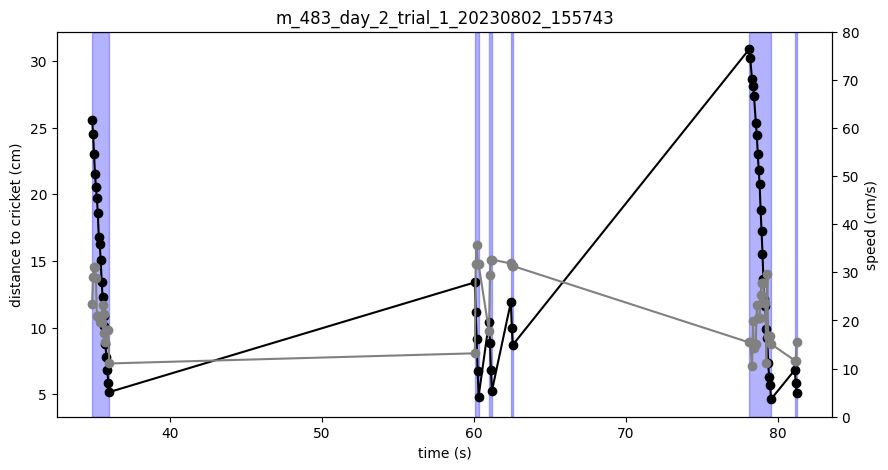

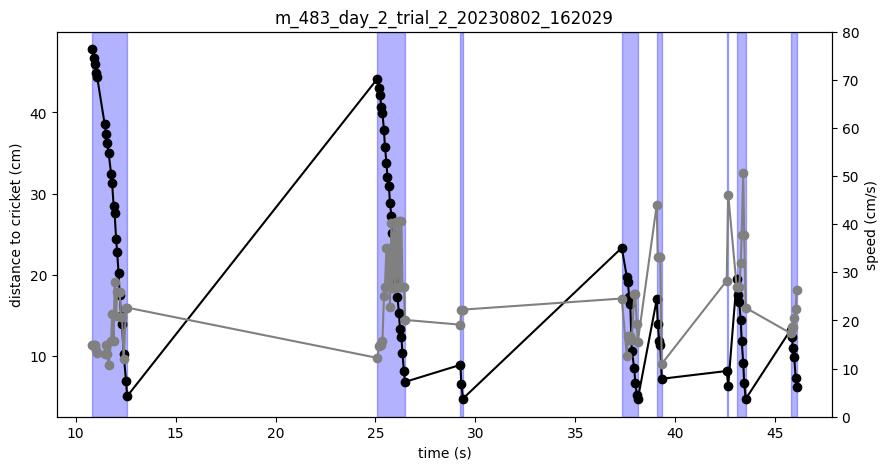

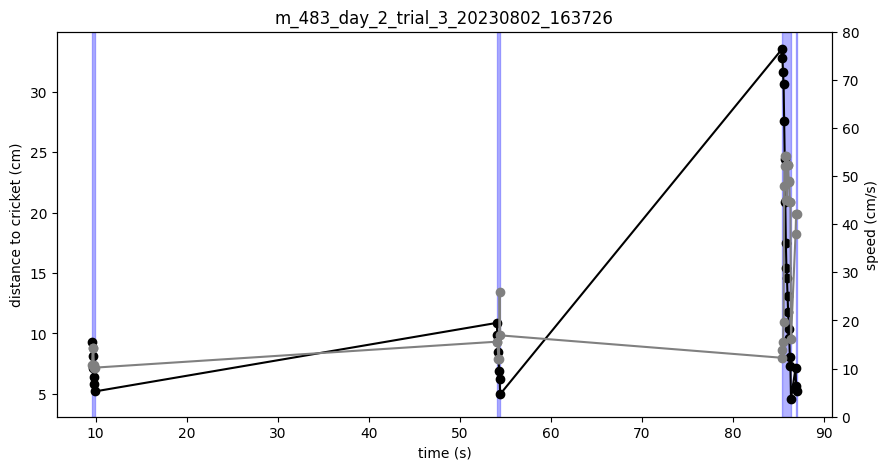

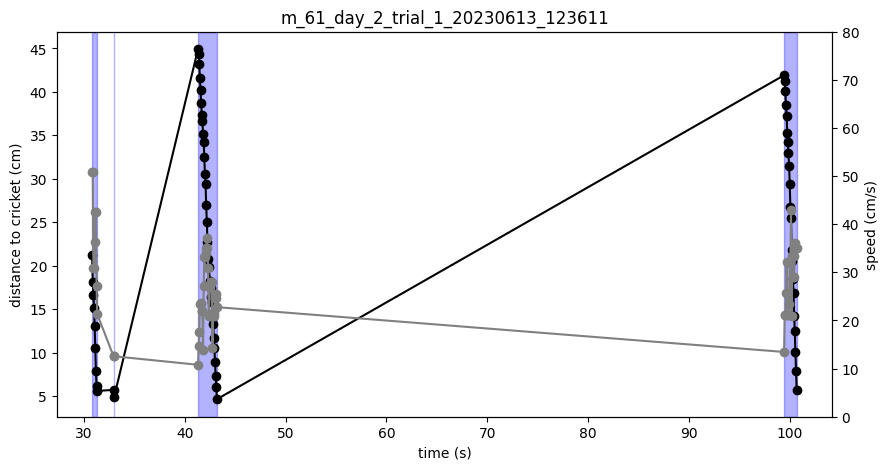

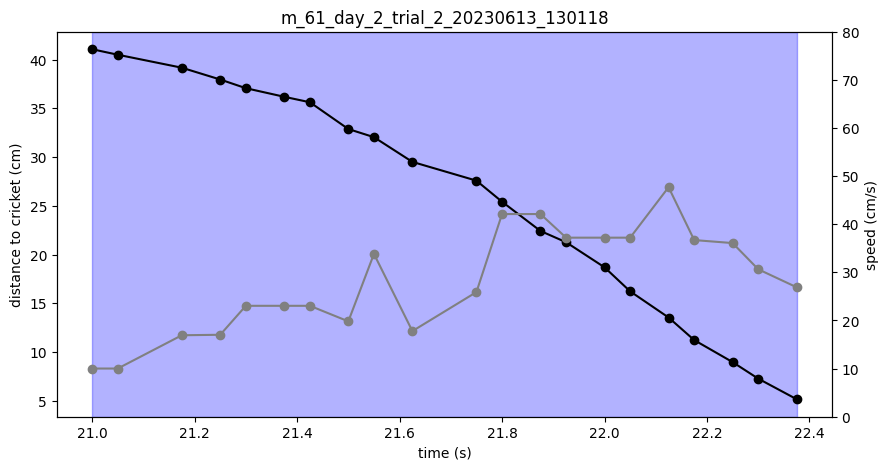

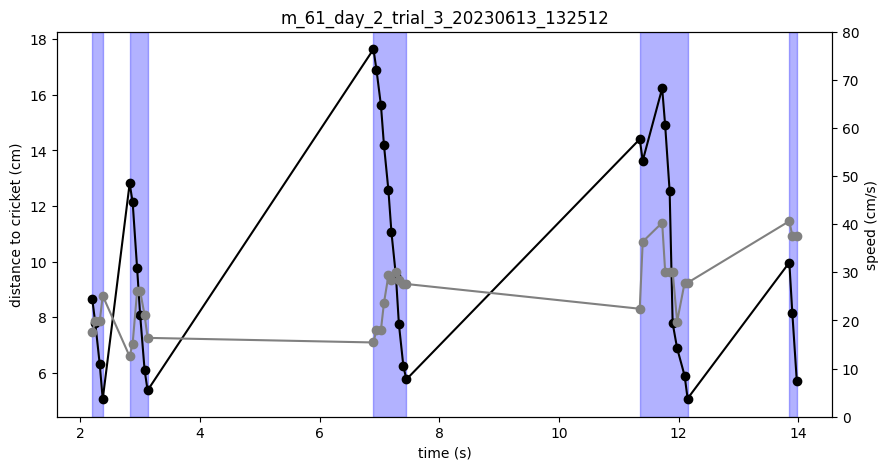

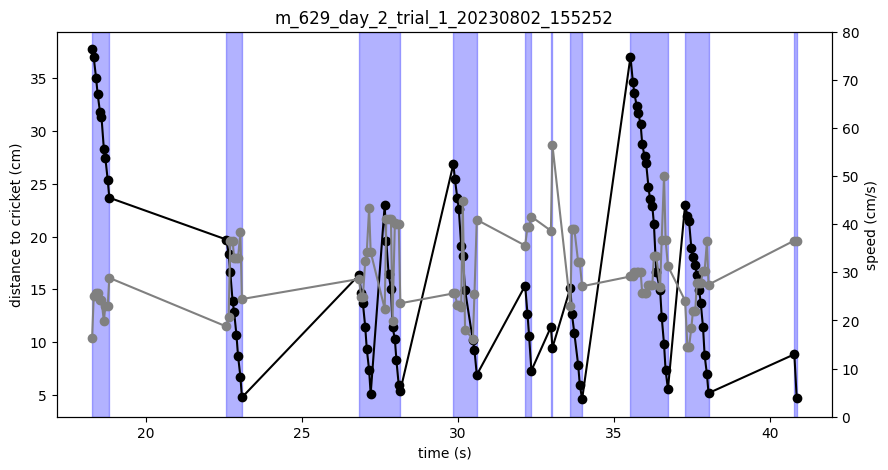

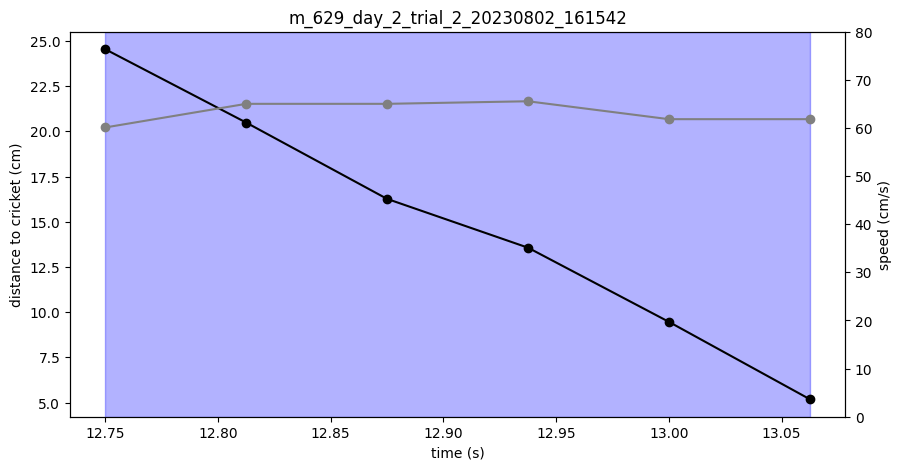

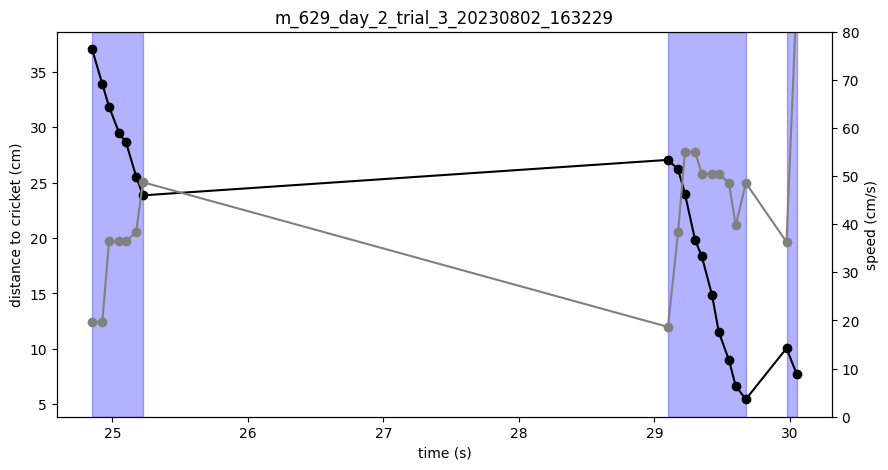

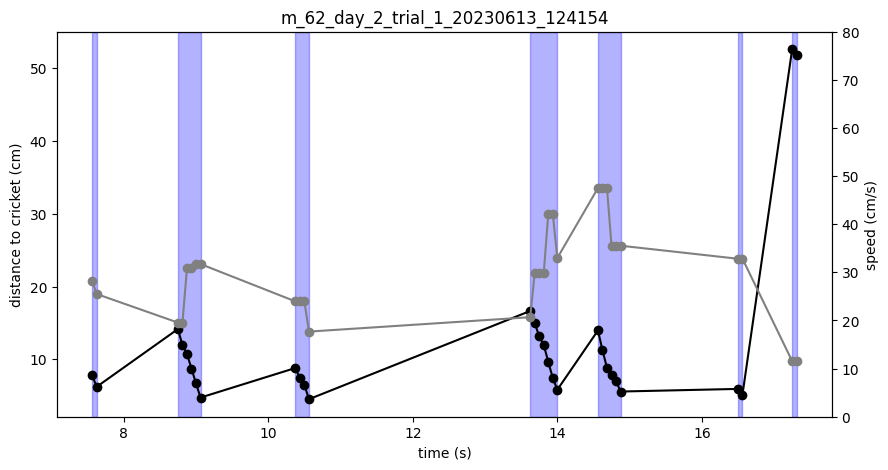

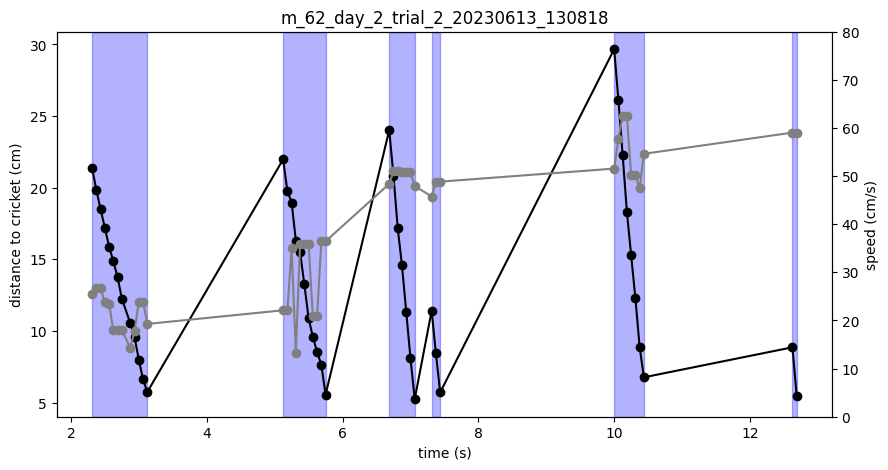

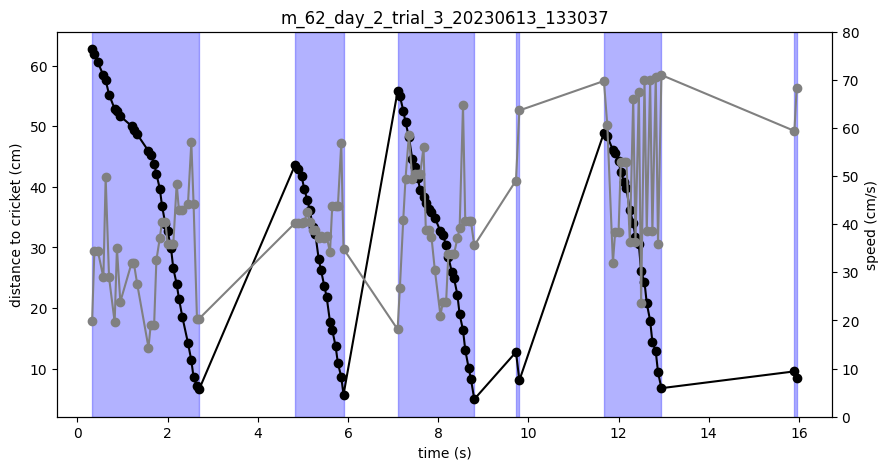

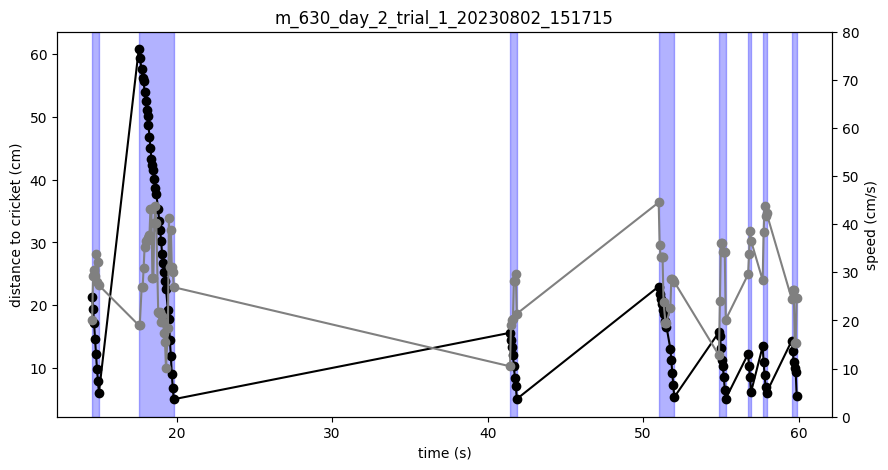

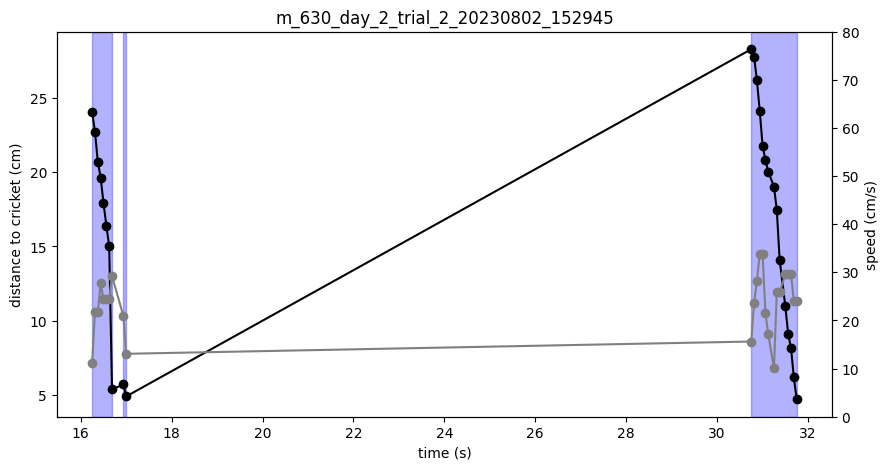

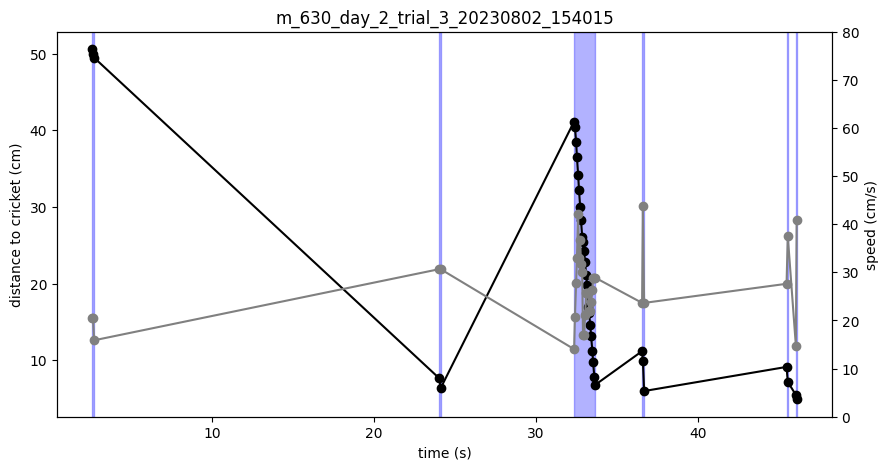

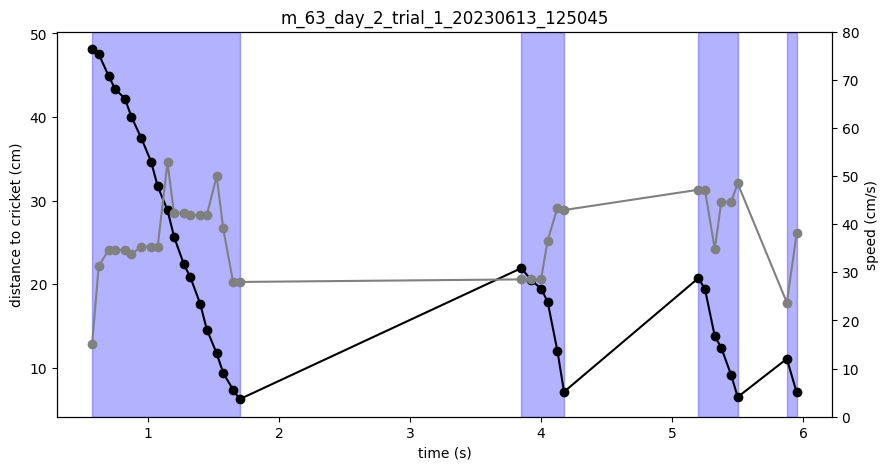

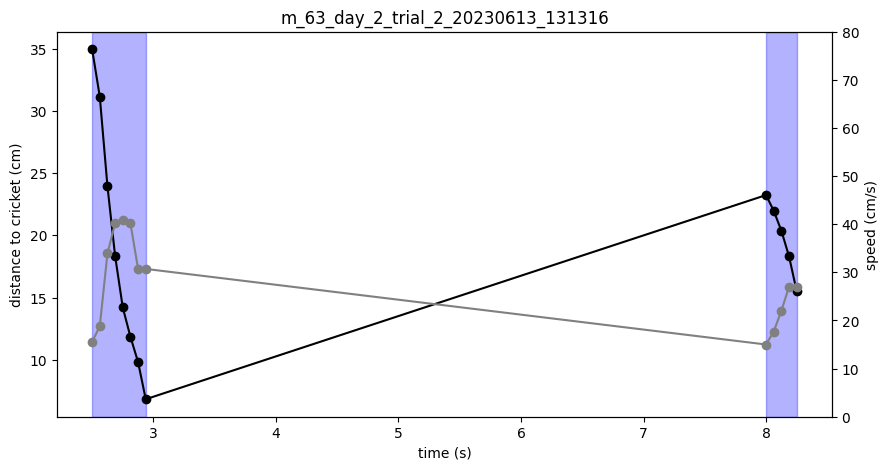

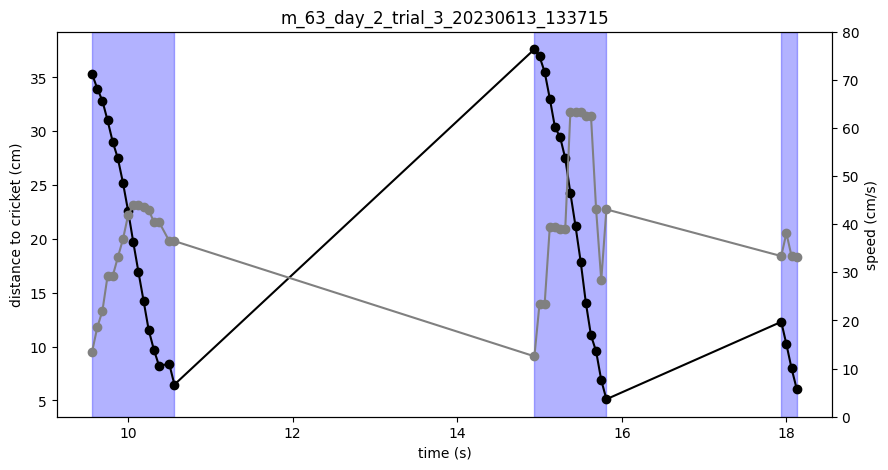

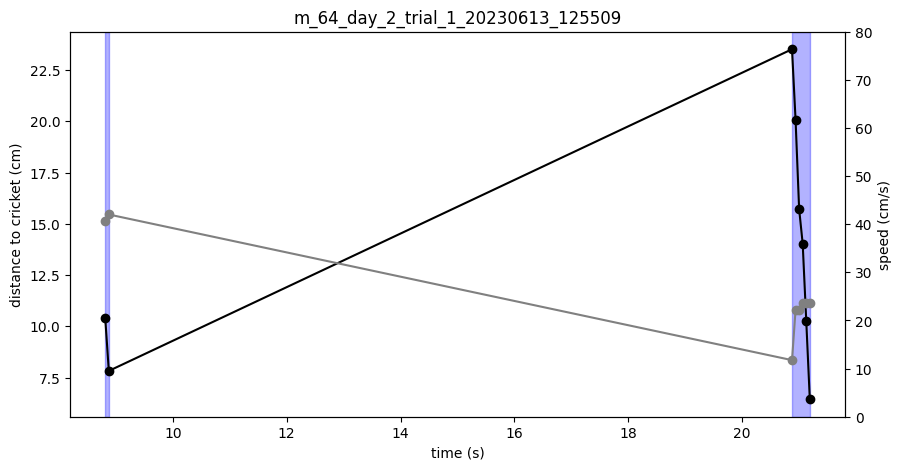

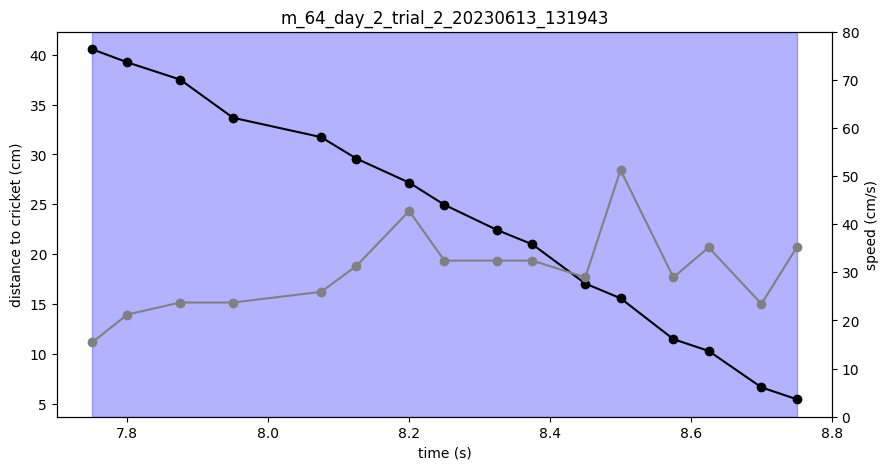

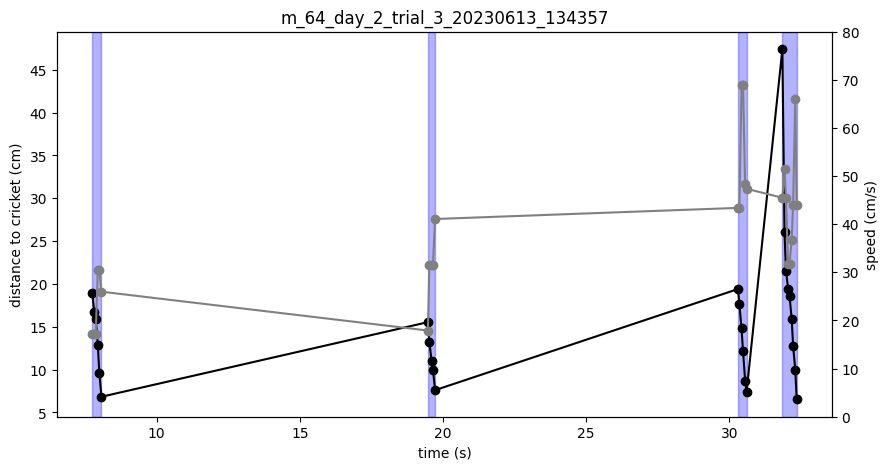

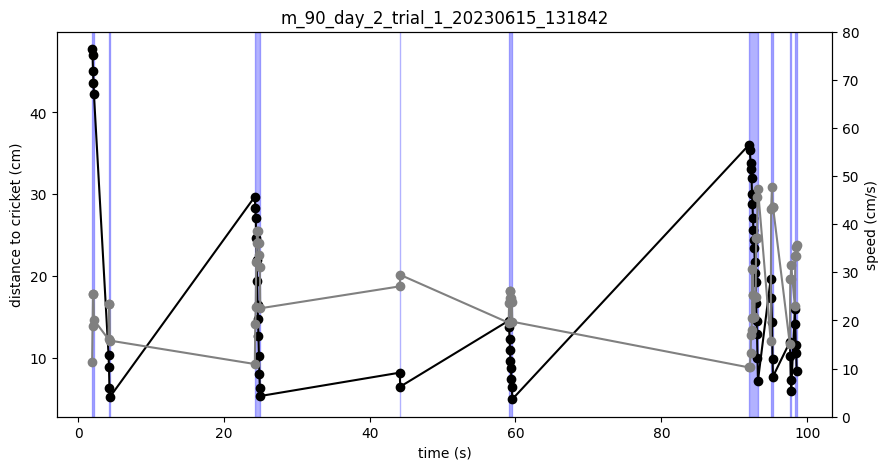

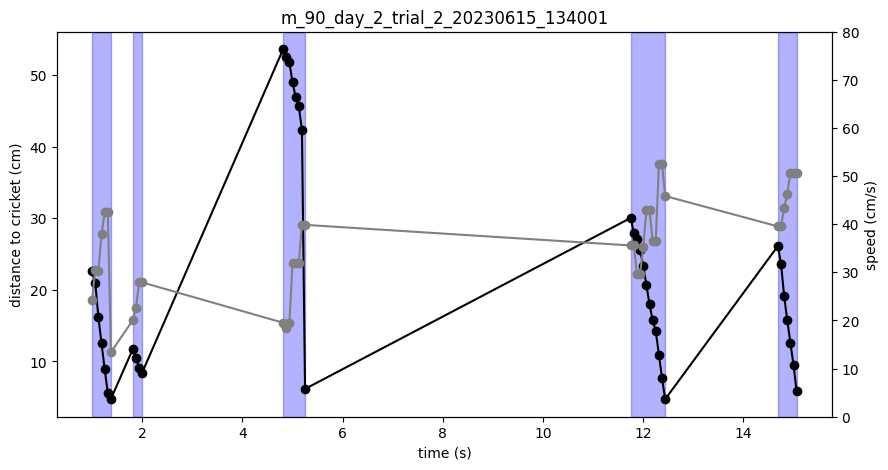

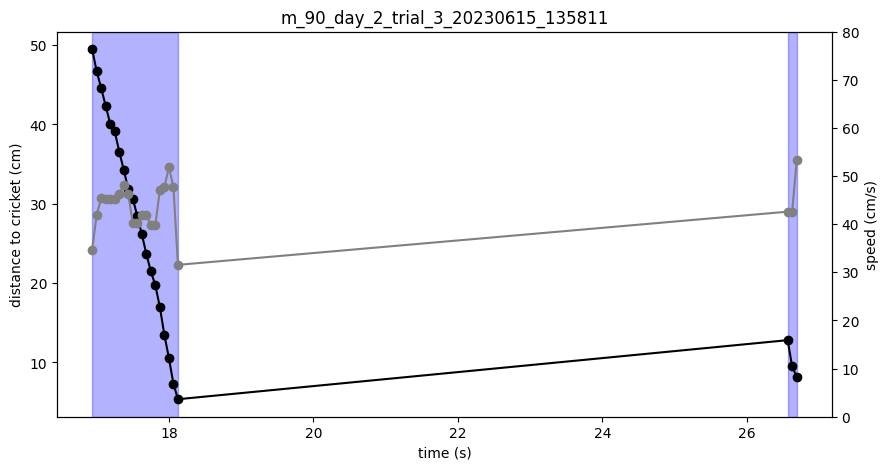

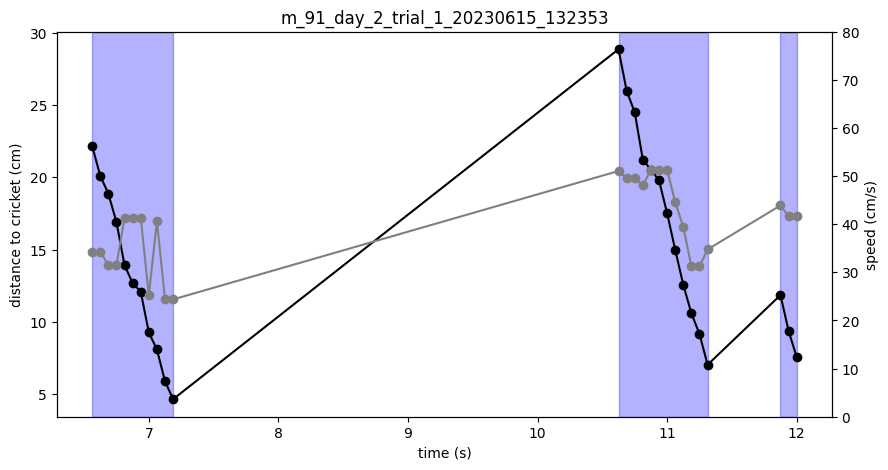

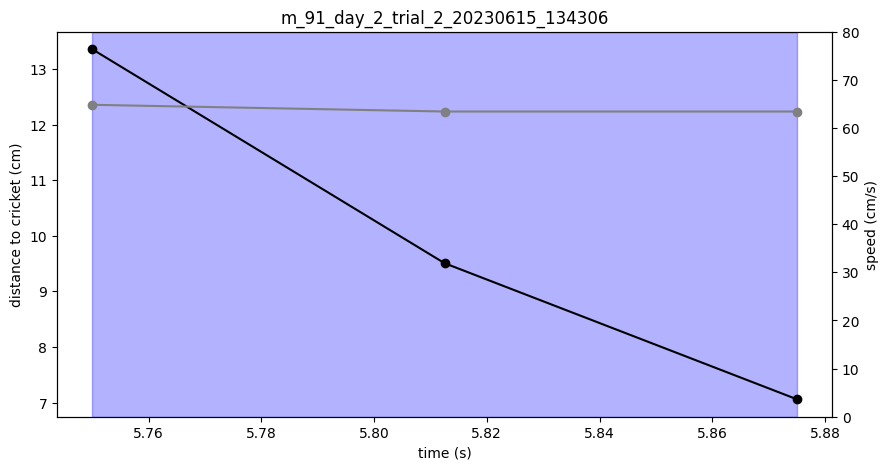

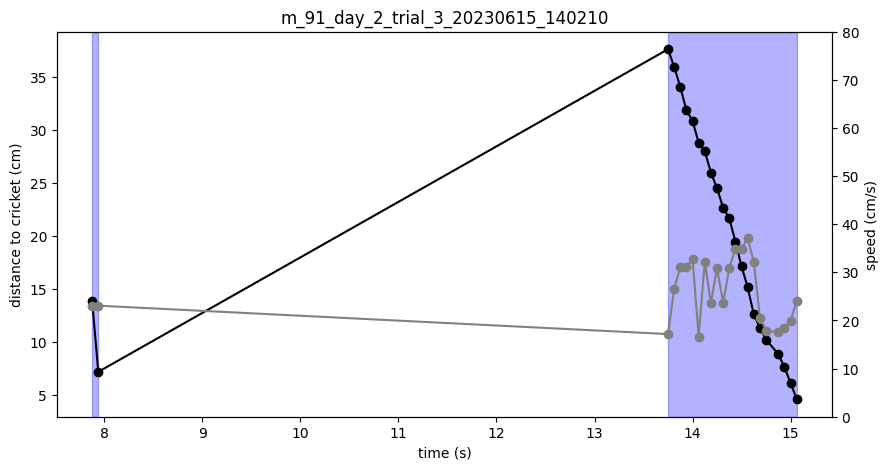

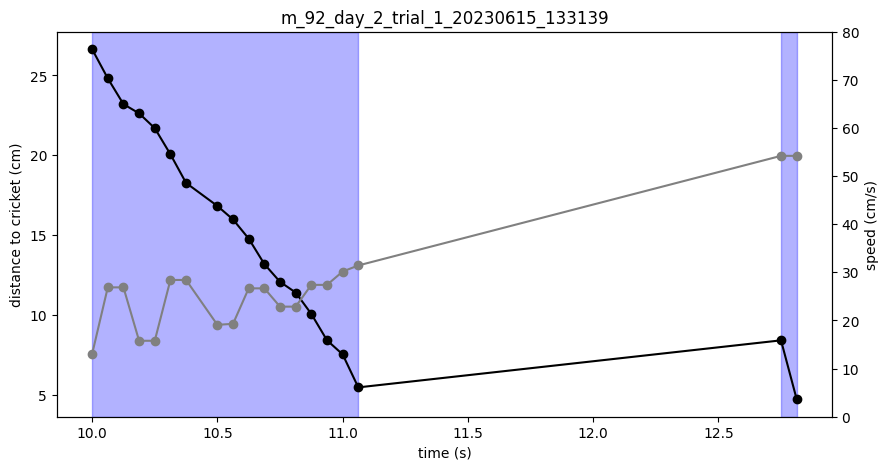

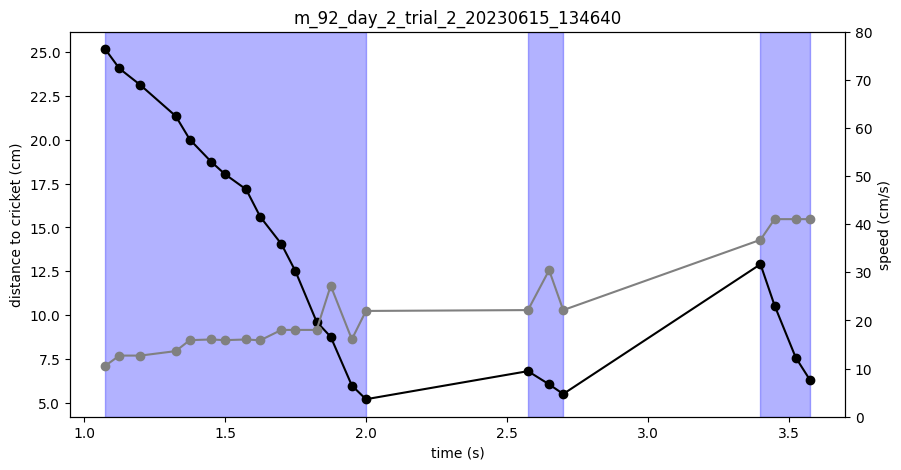

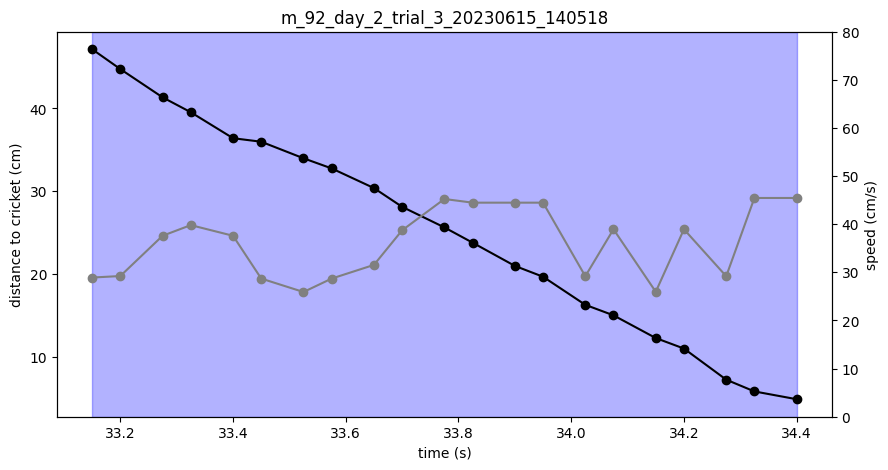

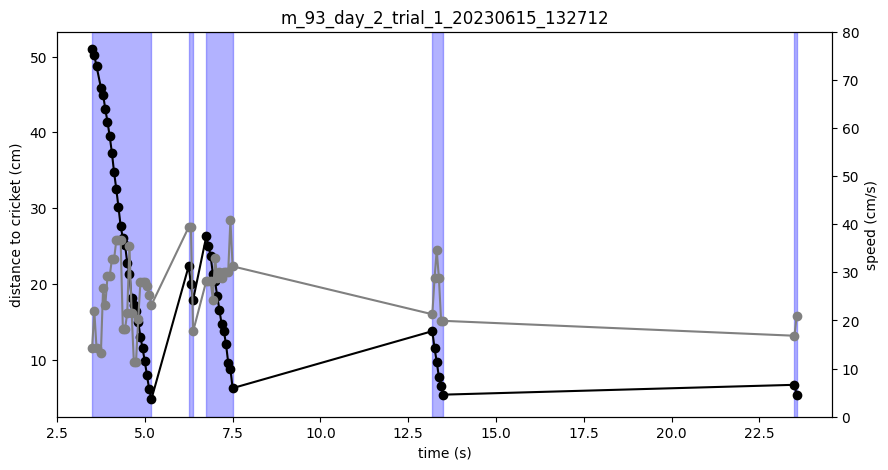

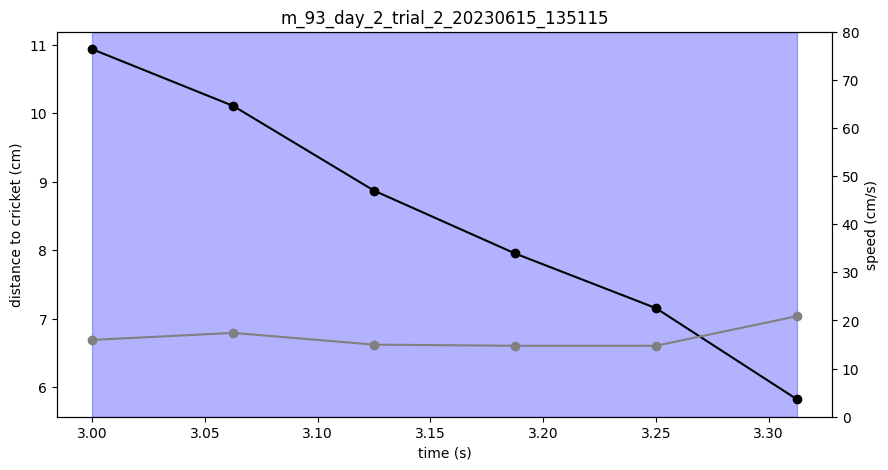

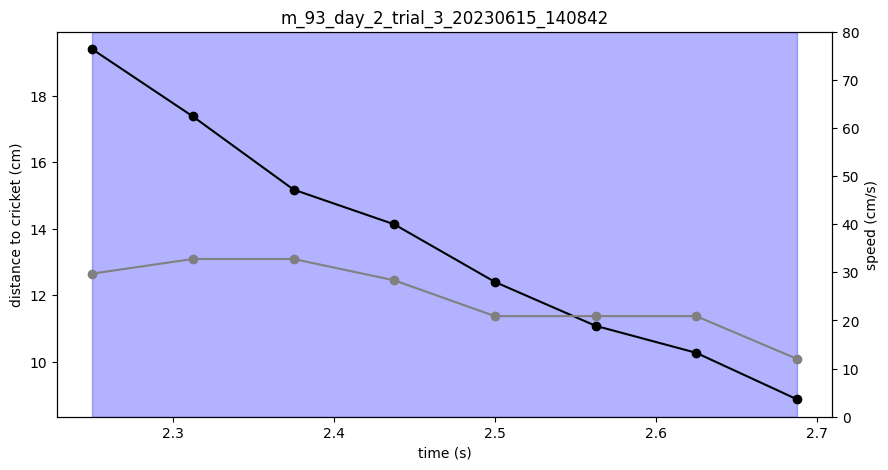

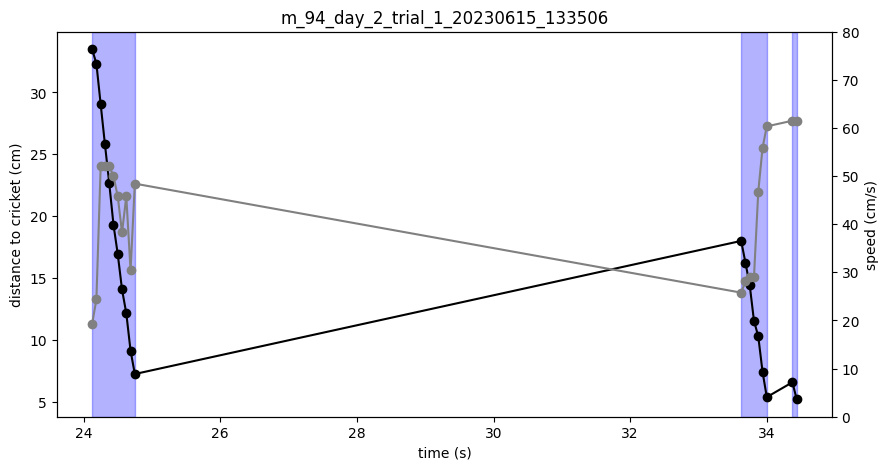

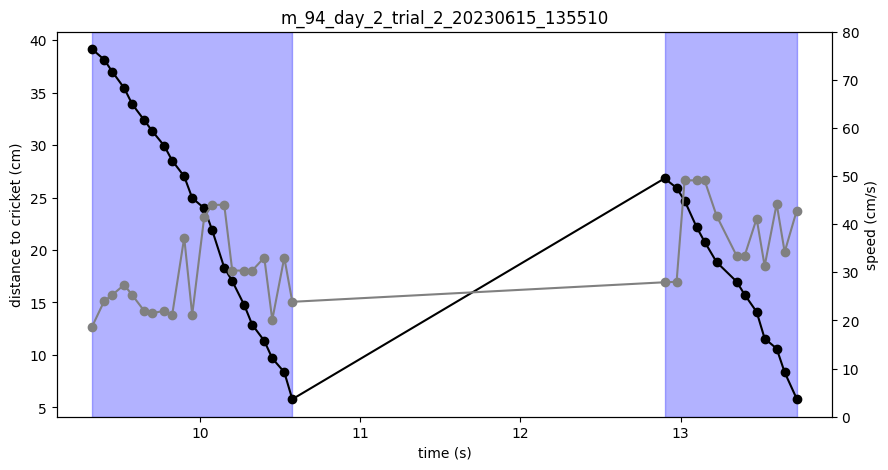

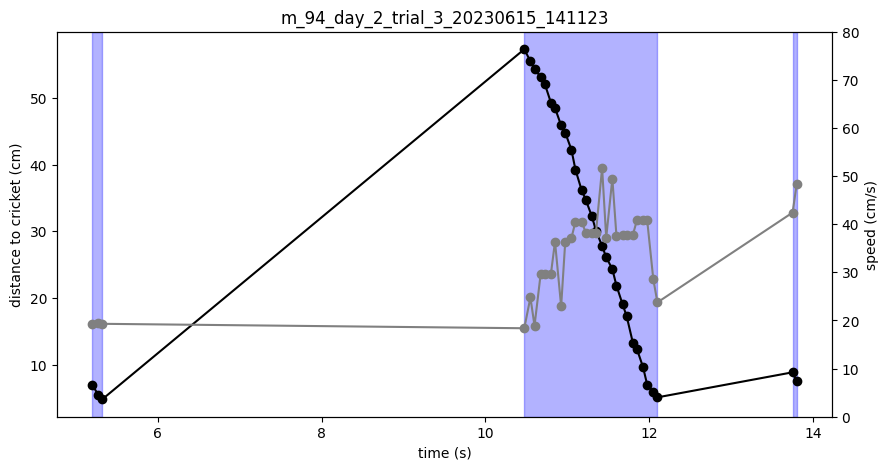

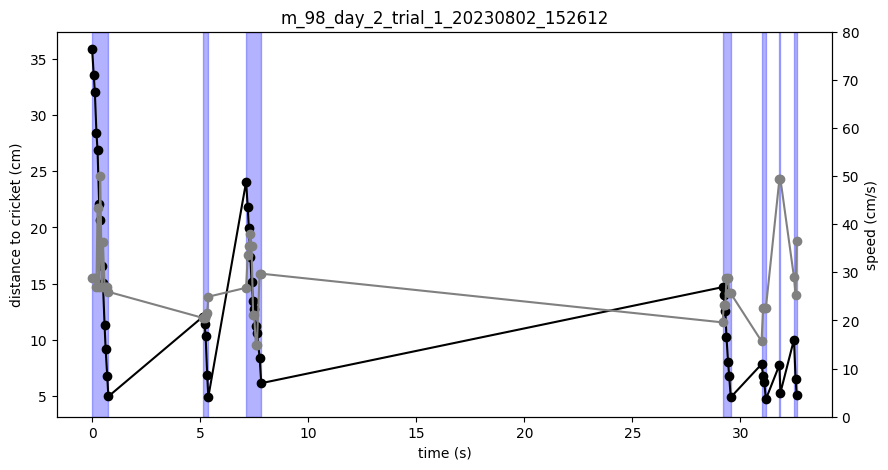

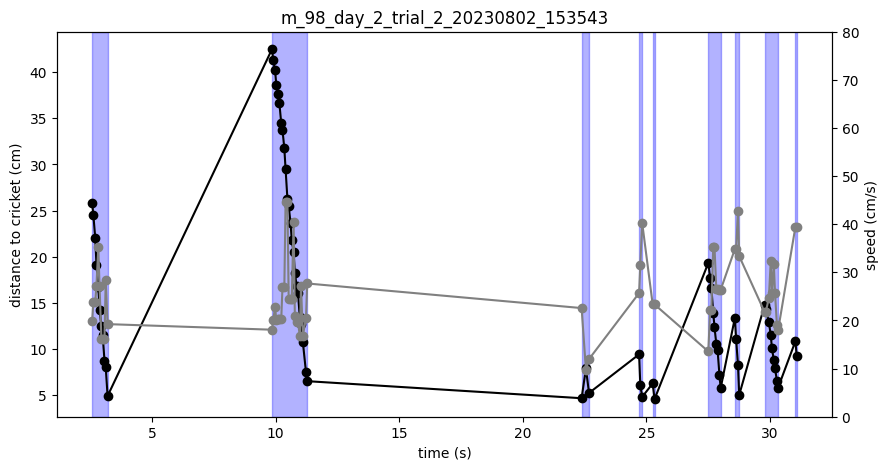

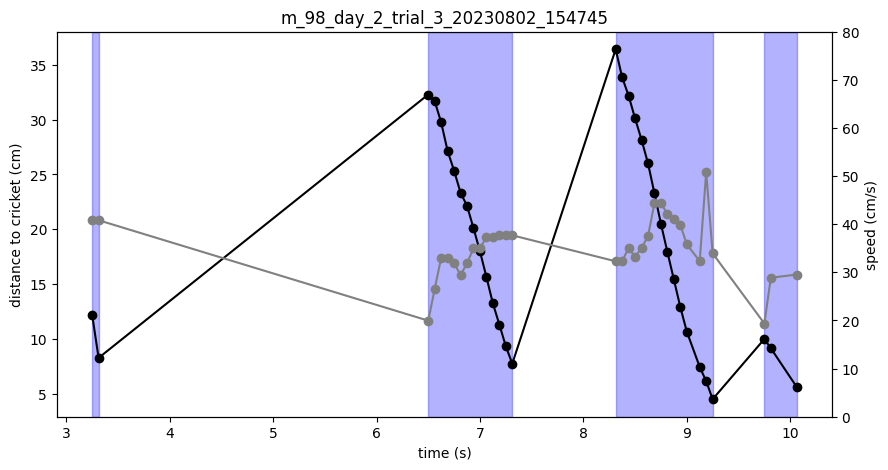

In [19]:
%matplotlib inline
behaviour_color={'exploration':'green','approach':'blue','contact':'red'}
herz=16
for session in raw_matrix_df['session'].unique():
    data=raw_matrix_df.query("session==@session &\
                            behaviour.notnull()").reset_index()
    
    # x=np.arange(0,len(data),1)/herz
    x=data['session_time']

    fig,ax=plt.subplots(1)
    ax.plot(x,data['distance_head_cricket_cm'],'-o',color='black')
    ax2=ax.twinx()
    ax2.plot(x,data['speed_cm_s_med_filt'],'-o',color='gray')

    for beh in data['beh_counter'].unique():
        data_beh=data.query('beh_counter==@beh')
        # x1=data_beh['beh_counter'].index[0] /herz
        # x2=data_beh['beh_counter'].index[-1] /herz
        x1=data_beh['session_time'].values[0]
        x2=data_beh['session_time'].values[-1]

        tipo_beh=data_beh['behaviour'].unique()[0]
        ax.axvspan(x1, x2, color=behaviour_color[tipo_beh], alpha=0.3)
        ax.set_title(session)

    ax.set_ylabel('distance to cricket (cm)')
    ax2.set_ylabel('speed (cm/s)')
    ax2.set_ylim(0,80)
    ax2.set_ylim(0,80)
    ax.set_xlabel('time (s)')


    fig.set_figheight(5)
    fig.set_figwidth(10)




## Stastistics of the different variables
Add a new level of agregation from the behavour matrix.
Aggregation by behaviour type for each day and for each trial

In [20]:
capture_time=(behaviour_matrix_df
              .groupby(['phenotype','mouse_num','day','trial','behaviour'])
              .agg(
                  diff_time=('diff_time',np.mean),
                  max_speed=('max_speed',np.mean),
                  mean_speed=('mean_speed',np.mean),
                  behaviour_count=('behaviour',len),
                  latency=('time_0',np.min),
                  max_speed_to_c=('max_speed_to_c',np.mean),
                  min_speed_to_c=('min_speed_to_c',np.mean),
                  mean_speed_to_c=('mean_speed_to_c',np.mean),
                  distance_to_c=('distance_to_c',np.mean),
                  capture_end=('time_end',np.max),
                  max_behaviour_dist=('max_behaviour_dist',np.mean),
                  min_behaviour_dist=('min_behaviour_dist',np.mean),
                  first_beh_distance=('first_beh_distance',np.mean),
                  mean_angle=('complex',circular_mean_angle),
                  magnitude=('complex',circular_magnitude))

                  ).reset_index()

display(capture_time)


,phenotype,mouse_num,day,trial,behaviour,diff_time,max_speed,mean_speed,behaviour_count,latency,max_speed_to_c,min_speed_to_c,mean_speed_to_c,distance_to_c,capture_end,max_behaviour_dist,min_behaviour_dist,first_beh_distance,mean_angle,magnitude
0,tg,62,2,1,approach,0.258929,31.143566,27.874601,7,7.5625,-15.447549,-34.798506,-25.117823,-6.671796,17.3125,17.137759,11.989276,17.137759,0.743663,0.672726
1,tg,62,2,2,approach,0.458333,47.433489,43.622697,6,2.3125,-32.181170,-48.681212,-40.638066,-15.958334,12.6875,19.548196,5.745240,19.548196,0.085678,0.910826
2,tg,62,2,3,approach,1.054167,63.593640,47.415484,6,0.3250,-17.532315,-62.822726,-35.622391,-33.229161,15.9500,38.883376,6.740493,38.883376,0.433336,0.980678
3,tg,63,2,1,approach,0.518750,45.712360,36.731296,4,0.5750,-20.080413,-72.523079,-43.288448,-20.122601,5.9500,25.457062,6.727704,25.457062,0.282941,0.974290
4,tg,63,2,2,approach,0.406250,33.970582,26.562340,2,2.5000,-26.375231,-80.045395,-48.153895,-21.302415,8.2500,29.107724,11.163991,29.107724,1.578450,0.738919
5,tg,63,2,3,approach,0.729167,48.501434,37.390408,3,9.5625,-17.414693,-47.955077,-33.973807,-24.682015,18.1250,28.406064,5.890692,28.406064,0.492541,0.809578
6,tg,91,2,1,approach,0.541667,45.520730,40.173066,3,6.5625,-16.490849,-46.682179,-31.543722,-16.766714,12.0000,20.965387,6.405884,20.965387,0.246592,0.999716
7,tg,91,2,2,approach,0.187500,64.817057,63.886372,1,5.7500,-39.147227,-61.574600,-51.313260,-9.621236,5.8750,13.354727,7.059613,13.354727,0.164966,1.000000
8,tg,91,2,3,approach,0.718750,30.085953,24.717948,2,7.8750,-19.477712,-74.229910,-46.265484,-21.089633,15.0625,25.736924,5.865239,25.736924,0.526846,0.853806
9,tg,93,2,1,approach,0.637500,34.497972,26.284657,5,3.5000,-17.541878,-41.073099,-27.591315,-17.409770,23.5625,24.025838,7.967045,24.025838,-0.058642,0.980256


## Capture time

Mean capture time for each mouse across 3 trials

In [21]:
capture_end=(raw_matrix_df
               .groupby(['phenotype','mouse_num','trial'])
               .agg( capture_end=('session_end_s',np.max))
               .groupby(['phenotype','mouse_num'])
               .agg( capture_end=('capture_end',np.mean))
                ).reset_index()
display(capture_end)

dm.data_summary(capture_end,'capture_end','phenotype')


,phenotype,mouse_num,capture_end
0,tg,62,16.095833
1,tg,63,12.345833
2,tg,91,12.375000
3,tg,93,14.770833
4,tg,94,23.562500
5,tg,98,28.325000
6,tg,479,29.450000
7,wt,26,103.229167
8,wt,28,149.225000
9,wt,61,49.441667


,mean,std,q1,q2,median,q3,ICR,max,min
phenotype,,,,,,,,,
tg,19.560714,7.407905,13.572917,16.095833,16.095833,25.943750,12.370833,29.450,12.345833
wt,58.371250,40.508762,32.022917,48.281250,48.281250,67.401042,35.378125,149.225,19.779167


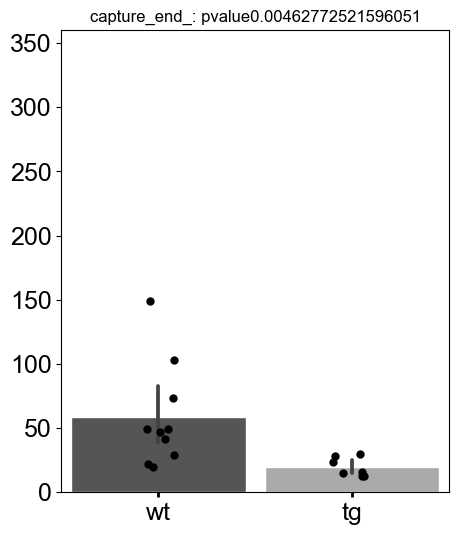

In [22]:
%matplotlib inline
x="phenotype"
y='capture_end'
data=capture_end.sort_values('phenotype',ascending=False)

fig,ax=plt.subplots()
sns.set_style('ticks') 

d=sns.barplot(x=x, 
            y=y,
            palette='gray',
            data=data,
            ax=ax,
            width=0.9)

# # Add in points to show each observation
sns.stripplot(data, x=x, y=y, size=6, color="black")
h,p=stats.mannwhitneyu(data.query("phenotype=='tg'")[y], data.query("phenotype=='wt'")[y], method="exact")
ax.set_title(f'{y}_: pvalue{p}')
ax.set_ylim(0,360)

ax.tick_params(axis='x', labelsize=18,direction='out',width=2)
ax.tick_params(axis='y', labelsize=18)
ax.set_xlabel('')
ax.set_ylabel('')
fig.set_figheight(6)
fig.set_figwidth(5)

# fig.savefig(figures_path+f'{y}_.tiff', bbox_inches='tight', dpi=300, format='tiff')


# Mean speed

In [23]:
mean_speed=(capture_time
               .groupby(['phenotype','mouse_num','behaviour'])
               .agg( mean_speed=('mean_speed',np.mean)
                   
               )).reset_index()
display(mean_speed.head())

dm.data_summary(mean_speed,'mean_speed',['phenotype','behaviour'])
mean_speed

,phenotype,mouse_num,behaviour,mean_speed
0,tg,62,approach,39.637594
1,tg,63,approach,33.561348
2,tg,91,approach,42.925795
3,tg,93,approach,22.512655
4,tg,94,approach,38.120731


,,mean,std,q1,q2,median,q3,ICR,max,min
phenotype,behaviour,,,,,,,,,
tg,approach,34.119278,6.818674,31.038410,33.561348,33.561348,38.879163,7.840753,42.925795,22.512655
wt,approach,32.672172,8.507986,26.395844,30.736598,30.736598,35.064022,8.668178,47.588679,23.195951


,phenotype,mouse_num,behaviour,mean_speed
0,tg,62,approach,39.637594
1,tg,63,approach,33.561348
2,tg,91,approach,42.925795
3,tg,93,approach,22.512655
4,tg,94,approach,38.120731
5,tg,98,approach,30.353138
6,tg,479,approach,31.723682
7,wt,26,approach,23.195951
8,wt,28,approach,28.355665
9,wt,61,approach,26.875576


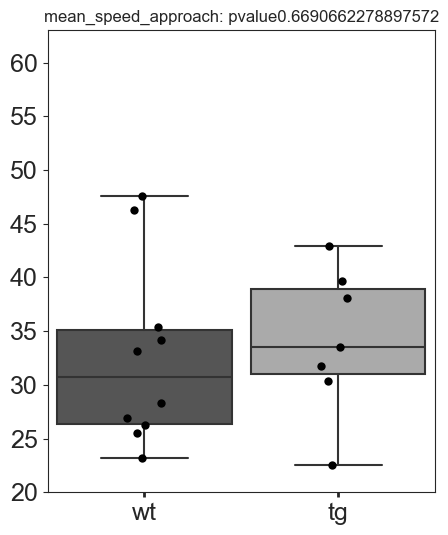

In [24]:
%matplotlib inline
x="phenotype"
y='mean_speed'
data_to=mean_speed.sort_values('phenotype',ascending=False)
for beh in data_to['behaviour'].unique():
    # Draw a nested boxplot to show bills by day and time
    data=data_to.query("behaviour==@beh")
    fig,ax=plt.subplots()
    sns.set_style('white')

    sns.boxplot(x=x, 
                y=y,
                palette='gray',
                data=data,
                ax=ax,
                width=0.9,
    )

    # sns.despine(offset=10, trim=True)

    # # Add in points to show each observation
    sns.stripplot(data, x=x, y=y, size=6, color="black")
    h,p=stats.mannwhitneyu(data.query("phenotype=='tg'")[y], data.query("phenotype=='wt'")[y], method="exact")
    ax.set_title(f'{y}_{beh}: pvalue{p}')
    ax.set_ylim(20,63)

    
    ax.tick_params(axis='x', labelsize=18,direction='out',width=2)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_xlabel('')
    ax.set_ylabel('')
    fig.set_figheight(6)
    fig.set_figwidth(5)

    fig.savefig(figures_path+f'{y}_{beh}.tiff', bbox_inches='tight', dpi=300, format='tiff')

## max speed

In [25]:
max_speed=(capture_time.sort_values('phenotype',ascending=False)
               .groupby(['phenotype','mouse_num','behaviour'])
               .agg( max_speed=('max_speed',np.mean)
                   
               )).reset_index()
display(max_speed.head())


dm.data_summary(max_speed,'max_speed',['phenotype','behaviour'])
max_speed

,phenotype,mouse_num,behaviour,max_speed
0,tg,62,approach,47.390232
1,tg,63,approach,42.728125
2,tg,91,approach,46.807913
3,tg,93,approach,29.384950
4,tg,94,approach,48.115124


,,mean,std,q1,q2,median,q3,ICR,max,min
phenotype,behaviour,,,,,,,,,
tg,approach,42.873748,7.266970,39.796253,46.807913,46.807913,47.752678,7.956425,48.825509,29.384950
wt,approach,42.147131,10.343952,34.918076,41.732848,41.732848,44.814606,9.896531,60.153238,26.790517


,phenotype,mouse_num,behaviour,max_speed
0,tg,62,approach,47.390232
1,tg,63,approach,42.728125
2,tg,91,approach,46.807913
3,tg,93,approach,29.384950
4,tg,94,approach,48.115124
5,tg,98,approach,36.864381
6,tg,479,approach,48.825509
7,wt,26,approach,26.790517
8,wt,28,approach,43.558060
9,wt,61,approach,38.685309


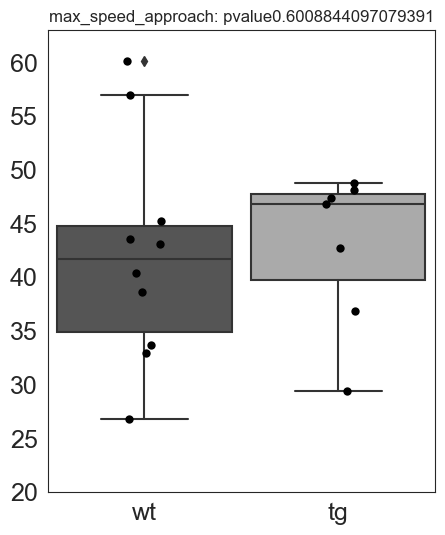

In [26]:
x="phenotype"
y='max_speed'
data_to=max_speed
for beh in data_to['behaviour'].unique():
    # Draw a nested boxplot to show bills by day and time
    data=data_to.query("behaviour==@beh")
    fig,ax=plt.subplots()
    sns.set_style('white')

    sns.boxplot(x=x, 
                y=y,
                palette='gray',
                data=data,
                ax=ax,
                width=0.9,
                order=['wt','tg']

    )

    # sns.despine(offset=10, trim=True)

    # # Add in points to show each observation
    sns.stripplot(data, x=x, y=y, size=6, color="black",order=['wt','tg'])
    h,p=stats.mannwhitneyu(data.query("phenotype=='tg'")[y], data.query("phenotype=='wt'")[y], method="exact")
    ax.set_title(f'{y}_{beh}: pvalue{p}')
    ax.set_ylim(20,63)

    
    ax.tick_params(axis='x', labelsize=18,direction='out',width=2)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_xlabel('')
    ax.set_ylabel('')
    fig.set_figheight(6)
    fig.set_figwidth(5)

    fig.savefig(figures_path+f'{y}_{beh}.tiff', bbox_inches='tight', dpi=300, format='tiff')

#### Save all tables for orientation analysis in a .csv

In [27]:
end_string=f'_day_{day}_thr_{thr}.csv'

# Save in analysed/tables folder
raw_matrix_df.to_csv(f'analysed/tables/analysed/approaches_end_contact_raw'+end_string)
last_approach_table.to_csv(f'analysed/tables/analysed/last_approaches_end_contact_raw'+end_string)
first_approach_table.to_csv(f'analysed/tables/analysed/first_approaches_end_contact_raw'+end_string)

# Save in circular statistics folder
raw_matrix_df.to_csv(f'circular_statistics/tables/approaches_end_contact_raw'+end_string)

